In [1]:
# %cd ../data/2019-10-07 21:25:11.994626-03:00_max_steps_4
%cd ..

/mnt/nas/GrimaRepo/aespinosa/pytorch-mac-network


In [2]:
import matplotlib
import fnmatch
import sys
sys.path.append('code')
# sys.path.append('Code')
from config import cfg, cfg_from_file
from mac import MACNetwork, load_MAC
import h5py
import numpy as np
import math
import os
import torch
from utils import load_label_embeddings, get_labels_concepts_filename
import matplotlib.pyplot as plt
import glob
import scipy
import seaborn as sns
sns.set()
from matplotlib.colors import Normalize, LinearSegmentedColormap
from IPython.core.display import display, Image
from PIL import Image as PILImage
import random
import mac
import time
import matplotlib
import pandas as pd
import nltk
nltk.download('punkt')
matplotlib.rcParams['figure.figsize'] = [125, 160]
matplotlib.rcParams['figure.max_open_warning'] = 50
def get_im_features(impath):
    img = PILImage.open(impath).convert('RGB')
    #img = transform(img)
    #img = img.to(device).unsqueeze(0)
    #features = resnet(img).detach()
    return img

def showImgAtt(img, atts, ax, imageDims = (11,11)):
    dx, dy = 0.05, 0.05
    x = np.arange(-1.5, 1.5, dx)
    y = np.arange(-1.0, 1.0, dy)
    X, Y = np.meshgrid(x, y)
    extent = np.min(x), np.max(x), np.min(y), np.max(y)

    #ax.cla()
 
    img1 = ax.imshow(img, interpolation="nearest", extent=extent)
    ax.imshow(atts.reshape(imageDims),
              cmap=plt.get_cmap('custom'),
              interpolation="bicubic",
              extent=extent)

    ax.set_axis_off()
    plt.axis("off")
    ax.set_aspect("auto")

def get_imgs(root_frames, video_id):
    img_folder = os.path.join(root_frames, str(video_id))
    image_list = []
    for filename in glob.glob(os.path.join(img_folder , '*.jpg')): #assuming jpg
        im = get_im_features(filename)
        image_list.append(im)
    return image_list

def get_labels(label_file, r_char=""):
    labels = []
    with open(label_file) as f:
        for line in f:
            labels.append(line.replace("\n","").replace(r_char,""))
            
    return labels

def get_positive_sample(root_data, model, split='train'):
    with h5py.File(root_data, 'r') as f:
        dataset = f[split]
        targets = list(np.unique(dataset['target']))
        inv_target = {v: i for i, v in enumerate(targets)}
        dataset_length = len(dataset['video_id'])
        positive = False
        while positive is False:
            ID = random.randint(0,dataset_length-1)
            print(ID)
            data = torch.from_numpy(dataset['data'][ID]).unsqueeze(0)
            target = dataset['target'][ID]
            scores, concepts_out = model(data)
            result = scores.squeeze().argmax()
            imgs = get_imgs(root_path_frames, ID)
            print("Predicted: ",label_list[result], targets[result], "\nGround truth:", label_list[inv_target[target]], target)
            con_at, vis_at = model.get_attentions()
            if target == targets[result]:
                positive = True
    
    return con_at.squeeze(), vis_at.squeeze(), imgs

def print_visual_attentions(attns, imgs, n = 5):
    image_dims = attns.shape[-2:]
    matplotlib.rcParams['axes.titlesize']=90
    n_steps, *_ = attns.shape
    matplotlib.rcParams['figure.figsize'] = [125, 20*n_steps]
    #attns = np.transpose(attns, axes=[1,0,2,3])
    reasoning_steps, n_frames , *_ = attns.shape
    frames = rank_frames(attns) # returns a list of reasoning_step length, where each element is a 5 element list, with frame indexes.
    cur_axis  = 0
    _, axes = plt.subplots(nrows=reasoning_steps,ncols=n)
    for step, attn in enumerate(attns):
        top_frames = rank_frames(attn)
        if len(imgs) < n_frames:
             imgs.extend([imgs[-1]] *
                        ((n_frames) - len(imgs)))
        
        for i, (sp_attn, img) in enumerate(zip(attn, imgs)): 
            if i in top_frames:
                axes[cur_axis//n][cur_axis%n].set_title("Step {} - Frame {}".format(step+1, i))
                showImgAtt(img, sp_attn, axes[cur_axis//n][cur_axis%n], image_dims)
                cur_axis+=1
                
def concept_attention(con_at):
    steps, _ = attn_concepts.shape
    matplotlib.rcParams['figure.figsize'] = [1.25*steps, 17.5]
    df = pd.DataFrame(np.array(con_at).transpose(), columns=range(1,steps+1))
    df = df.set_index(pd.Series(concept_list))
    # Default heatmap: just a visualization of this square matrix
    p1 = sns.heatmap(df, annot=True, cmap="Blues")
    p1.tick_params(right=False, top=True, labelright=False, labeltop=True)
    p1.set_ylim(p1.get_ylim()[0] + 0.5, p1.get_ylim()[1] - 0.5)
    print("")
    
def rank_frames(attn, n = 5):
    result = []
    s = np.sum(attn, axis=(1,2))
    return s.argsort()[-n:][::-1]

def video_attention(vis_at):
    steps, *_ = vis_at.shape
    matplotlib.rcParams['figure.figsize'] = [25, 0.75*steps]
    frames = vis_at.sum(2).sum(2)
    sums = np.linalg.norm(frames,axis=1)
    for i, s in enumerate(sums):
        frames[i] = frames[i]/s
    #print(np.linalg.norm(frames,axis=1))
    row_sums = frames.sum(axis=0)
    #frames = frames / row_sums[:, np.newaxis]
    #frames /= np.linalg.norm(frames, ord=2, axis=1, keepdims=True)
    steps, n_frames = frames.shape
    df2 = pd.DataFrame(np.array(frames), columns=range(1, n_frames+1))
    df2 = df2.set_index(pd.Series(["Paso {}".format(i) for i in range (1,steps+1)]))
    p1 = sns.heatmap(df2, annot=False, cmap="Blues")
    p1.set_xticklabels(p1.get_xticklabels(), rotation=45)
    p1.set_yticklabels(p1.get_yticklabels(), rotation=0)
    p1.set_ylim(p1.get_ylim()[0] + 0.5, p1.get_ylim()[1] - 0.5)
    print()

## NOT USED!
def print_concept_attentions(attn_concepts, concept_list):
    
    r_steps, _ = attn_concepts.shape
    attn_concepts = np.transpose(attn_concepts)
    padding = 60
    print("-"*padding, end="")
    for i in range(1,r_steps+1):
        print("{:<5}\t".format(i), end="")
    print("")
    for concept, specific_attention in zip(concept_list, attn_concepts): # Over concepts
        print("{:<{padding}}: ".format(concept, padding=padding-2), end="")

        for i, attn in enumerate(specific_attention): # Over reasoning steps
            print ("{:.2f}%\t".format(100*attn), end="")
        print("")
# How to use: print_concept_attentions(attn_concepts, concept_list )

cdict = {
    "red": ((0.0, 0.0, 0.0), (0.6, 0.8, 0.8), (1.0, 1, 1)),
    "green": ((0.0, 0.0, 0.0), (0.6, 0.8, 0.8), (1.0, 1, 1)),
    "blue": ((0.0, 0.0, 0.0), (0.6, 0.8, 0.8), (1.0, 1, 1))
}
cdict["alpha"] = ((0.0, 0.35, 0.35), (1.0, 0.65, 0.65))
plt.register_cmap(name="custom", data=cdict)

[nltk_data] Downloading package punkt to /home/aespinosa/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Parameter Setting

In [7]:
cfg_from_file(config_file)

# USUAL PARAMETERS TO CHANGE
ema = True
repo_path = '.'
checkpoint_dir_name = '2019-10-07 21:25:11.994626-03:00_max_steps_4'
# END PARAMETERS 

root_path = "/vault/caspillaga/actions_transformations/s2s_feats_10percent_i3d.h5"
root_path_frames = "/workspace1/jahurtado/20BN-SOMETHING-SOMETHING-V2-1/20bn-something-something-v2-frames/"
labels_concepts_filename, concepts_file_path = get_labels_concepts_filename(cfg, get_concept_names_filename=True)
checkpoint_dir = os.path.join(repo_path, 'data', checkpoint_dir_name)

for file in os.listdir(checkpoint_dir):
    if fnmatch.fnmatch(file, '*.yml'):
        config_file = os.path.join(checkpoint_dir , file)
        break
if ema:
    pattern = 'best*ema*.pth'
else:
    pattern = 'best*.pth'
for filename in os.listdir(os.path.join(checkpoint_dir, 'Model')):
    if fnmatch.fnmatch(filename, pattern):
        checkpoint_path = os.path.join(checkpoint_dir, 'Model', filename)
        break
#checkpoint_path = "/mnt/nas/GrimaRepo/aespinosa/pytorch-mac-network/data/2019-09-26 08:00:14.516096-03:00_max_steps_8/Model/best_model_ema_checkpoint_000014.pth"
#config_file = "/mnt/nas/GrimaRepo/aespinosa/pytorch-mac-network/data/2019-09-26 08:00:14.516096-03:00_max_steps_8/s2s_maxstep8_dp0.25_bs15.yml"

concept_list = get_labels(concepts_file_path, r_char=" ")
label_list = get_labels(cfg.PREPROCESS.LABEL_NAMES_PATH)

In [8]:
concept_list

['dropping',
 'next',
 'folding',
 'holding',
 'behind',
 'moving',
 'away',
 'closer',
 'picking',
 'pretending',
 'close',
 'without',
 'actually',
 'closing',
 'take',
 'throw',
 'pushing',
 'almost',
 'falls',
 "n't",
 'putting',
 'number',
 'onto',
 ',',
 'table',
 'removing',
 'revealing',
 'scooping',
 'showing',
 'top',
 'throwing',
 'air',
 'catching',
 'tilting']

## Model Loading

In [9]:
import mac

vocab = {'question_token_to_idx': [] }
mac.device = torch.device('cpu')
model, model_ema, _ = load_MAC(cfg) #, vocab, labels_matrix, concepts)
ck = torch.load(checkpoint_path, map_location='cpu')
model.load_state_dict(ck['model'], strict=True)

<All keys matched successfully>

## Executing Model

In [10]:
attn_concepts, attn_visual, imgs = get_positive_sample(root_path, model)
print("")

15628
Predicted:  Pretending to close something without actually closing it 7 
Ground truth: Pretending to close something without actually closing it 7



## Concept Attention

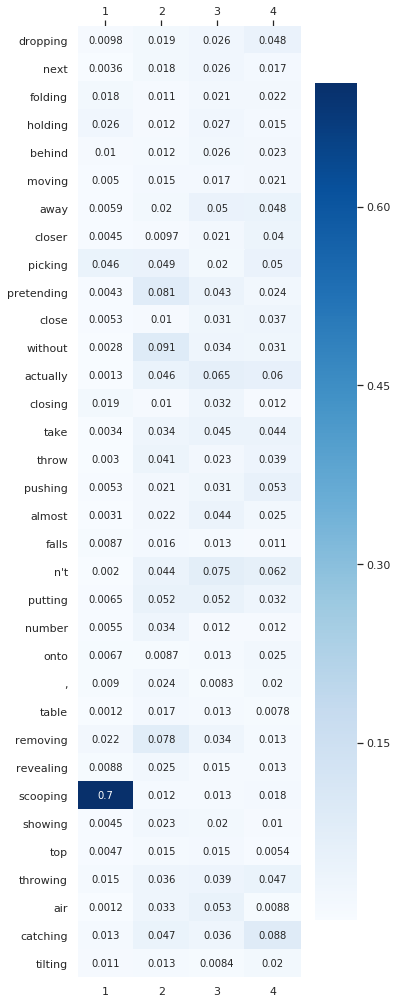

In [11]:
concept_attention(attn_concepts)

## Visual Attention

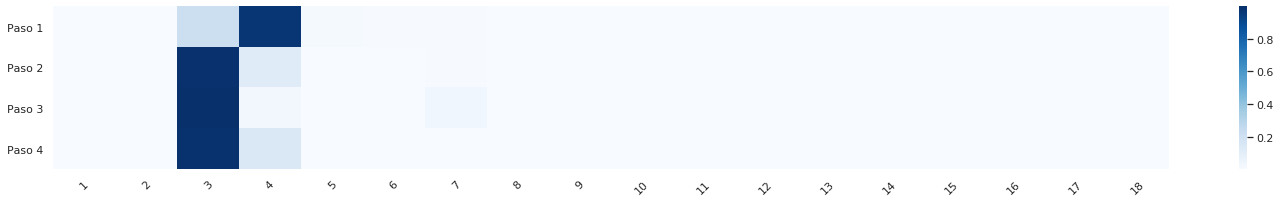

In [12]:
video_attention(attn_visual)

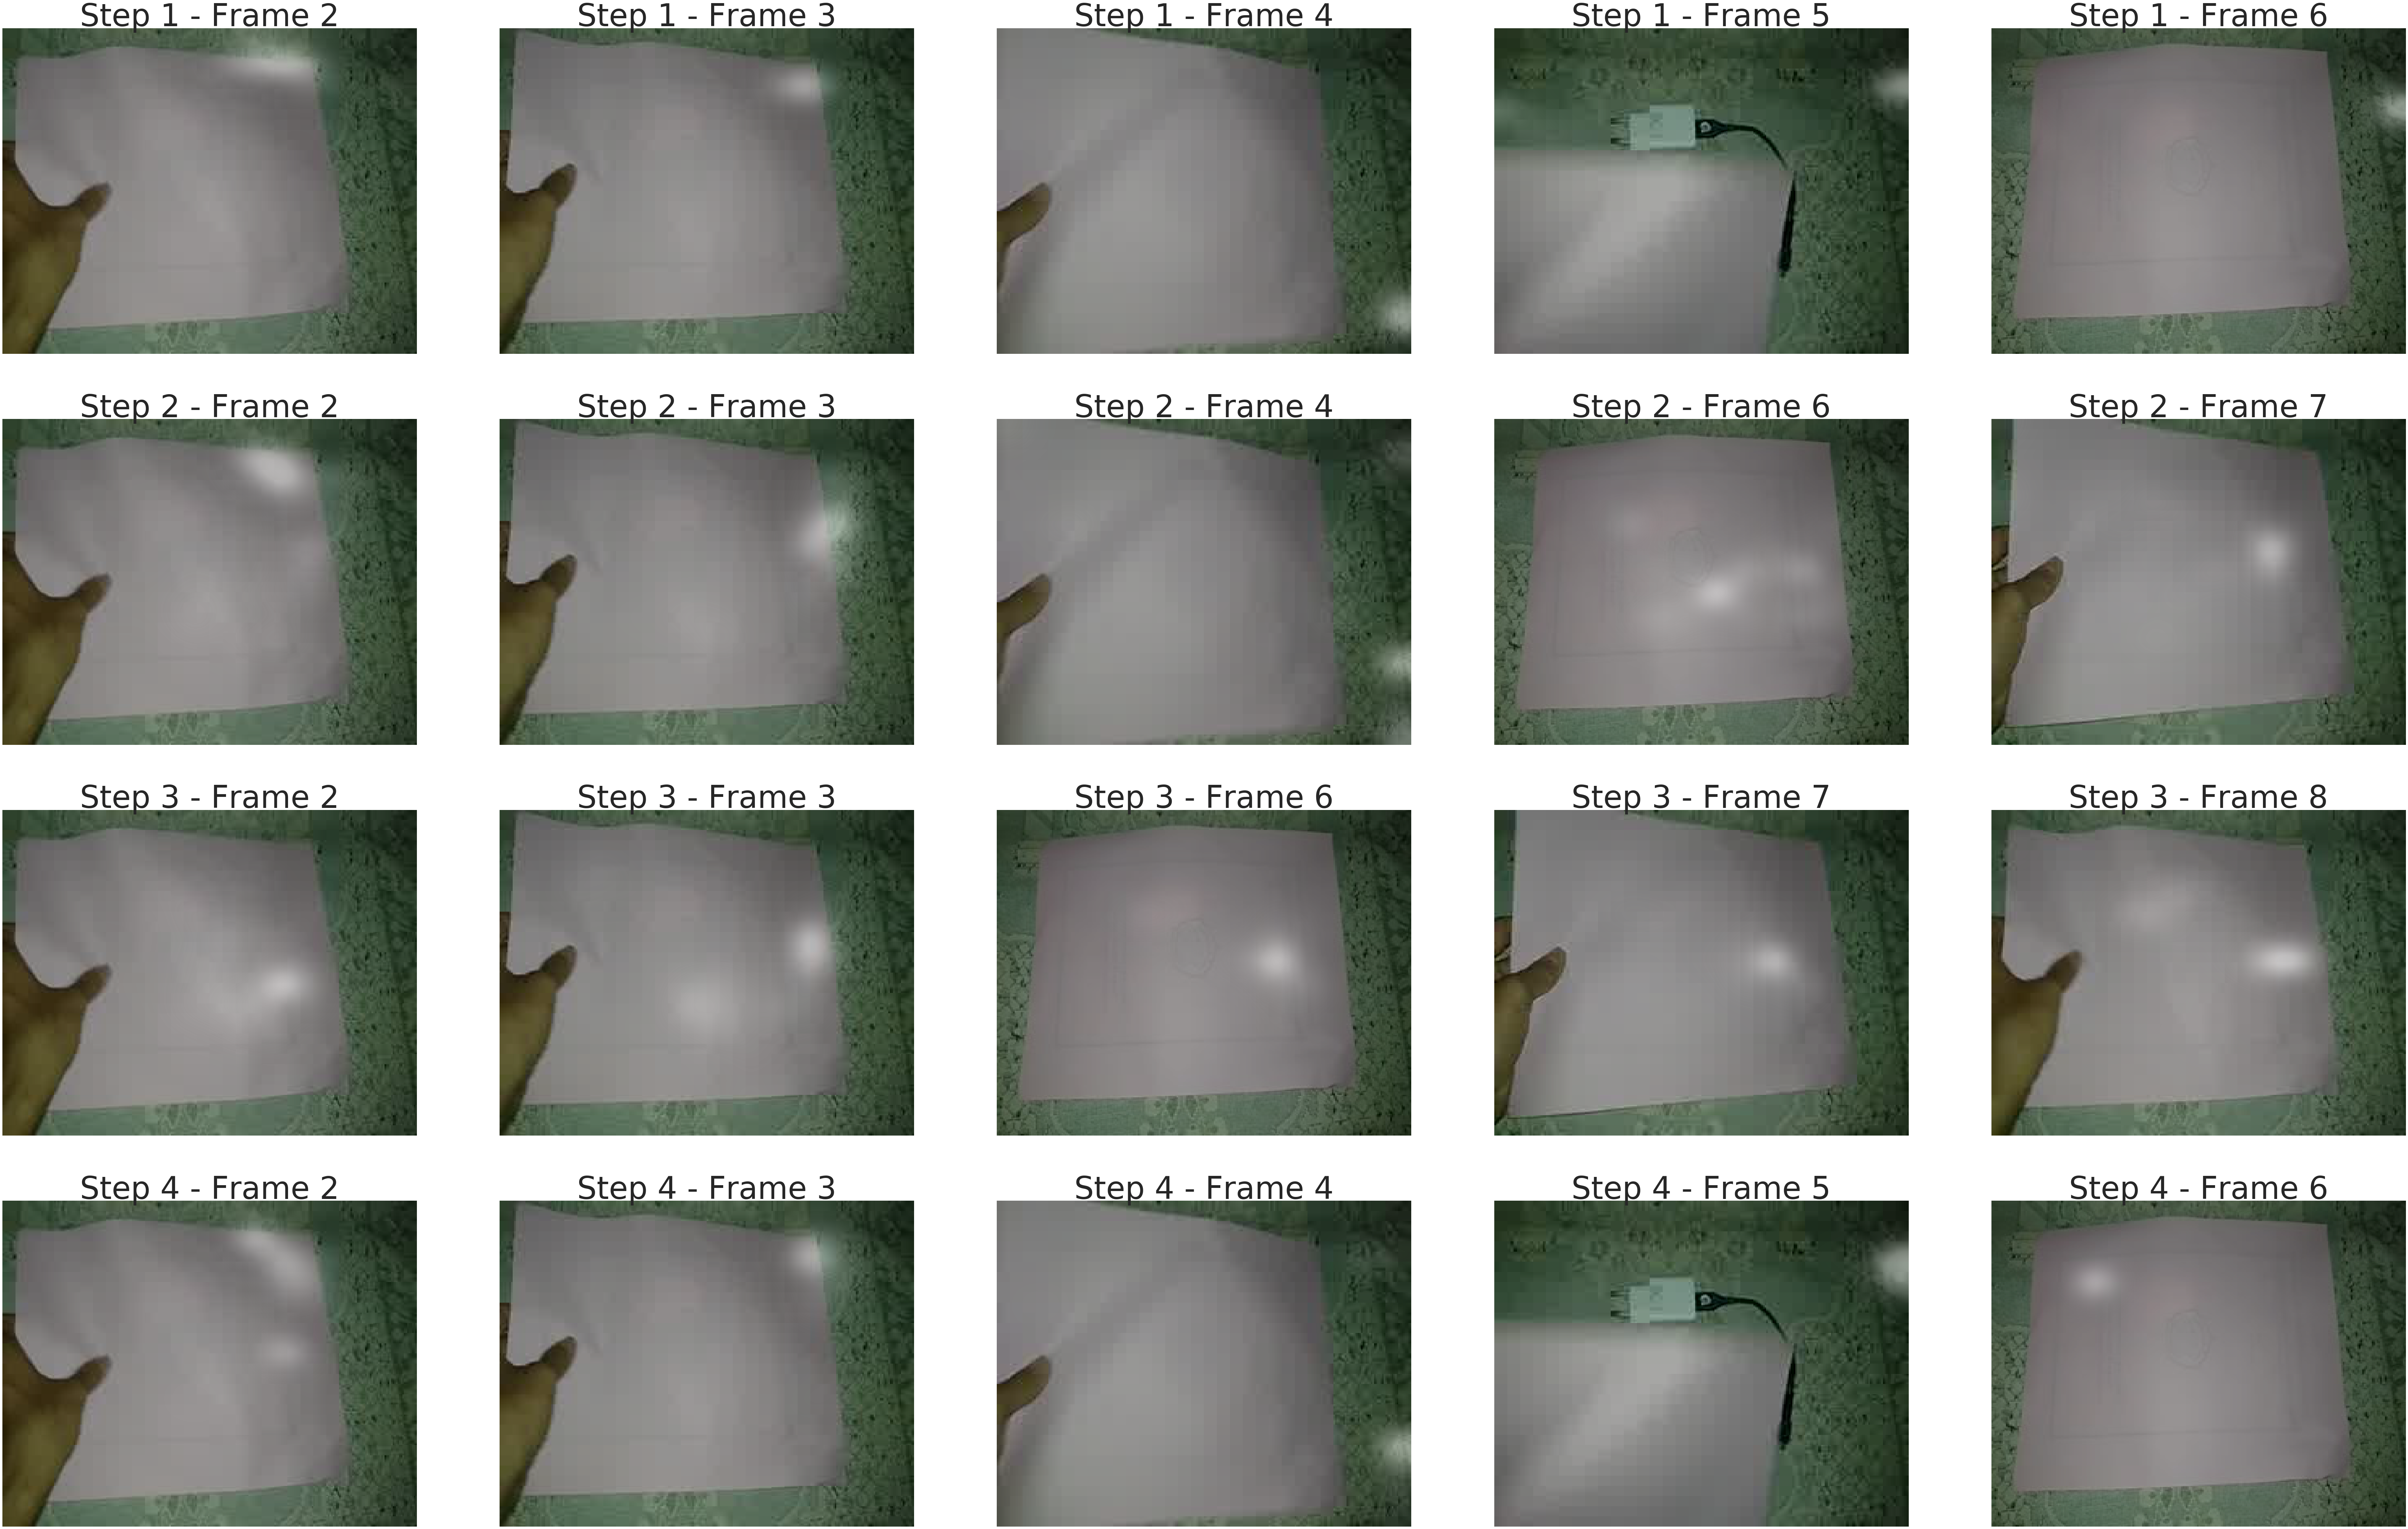

In [13]:
print_visual_attentions(attn_visual, imgs)